In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import pandas as pd

In [3]:
home_folder = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/'
# we need to coordinates file to access the corner points - glamf/gphif
model_mask_file = home_folder + 'GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values

# additionaly load the following fields to 
lats_new=mask_ds['nav_lat'].values
lons_new=mask_ds['nav_lon'].values


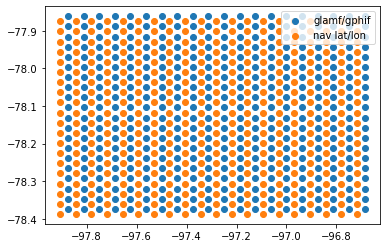

In [3]:
x=mask_ds['glamf']
y=mask_ds['gphif']

# get the mask values of the corner points
c=mask_ds['tmask'][:]
fig=plt.figure()
ax=plt.axes()

ax.scatter(x[0,:20,:20],y[0,:20,:20],label='glamf/gphif')
ax.scatter(mask_ds['nav_lon'][:20,:20],mask_ds['nav_lat'][:20,:20], label='nav lat/lon')
ax.legend()

<h4> Given a delta value- resolution of particles to be relased across a regular grid, compute the lats and lons of release points. \n Benguela Upwelling region lies between 10E-20E and 35S-20S ().

In [31]:
# Only upwelling region: (961, 641), 0.0625/4: #n: 370831
# left_lon = 10.0
# right_lon = 20.0
# top_lat = -15
# bottom_lat = -35

# extra region- FTLE: (1601, 1025), 0.0625/4 #n 1m
left_lon = 5
right_lon = 20
top_lat = -15
bottom_lat = -35

# Test region : near Cape Cauldron
# left_lon = 17.5
# right_lon = 19
# top_lat = -32.5
# bottom_lat = -34.5

den=16
delta= 1/den
# delta = 0.0625/4  # divided by 4 (1601, 1025) 
# n=1,161,543(linear, but particles near 21E), 1,153,714(nearest) and without (401, 257) n=72,842

lons = np.arange(left_lon, right_lon + delta, delta)
lats = np.arange(bottom_lat, top_lat + delta, delta)
regions_lons, regions_lats = np.meshgrid(lons, lats)
print(regions_lons.shape)
print(delta)

(321, 241)
0.0625


In [54]:
points = list(zip(regions_lons.flatten(), regions_lats.flatten()))
release_lons, release_lats = zip(*points)
print(len(release_lons))

103057


<h4>griddata function doesnt work well for curvilinear data - hence the masking related issues.

In [55]:
land_val_release = griddata((lons_new.ravel(), lats_new.ravel()), mask_land[0,0,:,:].ravel(),
                            (regions_lons, regions_lats), method='nearest', fill_value=0)     # Method 1- improved masking with nav_lat and nav_lon
# land_val_release = griddata((mask_lon[0, :-1, :-1].ravel(), mask_lat[0, :-1, :-1].ravel()), mask_land[0,0,1:,1:].ravel(),
#                             (regions_lons, regions_lats), method='nearest', fill_value=0)   # Method 2 much better masking

#see below comparison for 1/16th release and different methods of filtering.

bool_mask = land_val_release.astype(bool)
ocean_lons = regions_lons[bool_mask]
ocean_lats = regions_lats[bool_mask]
len(ocean_lats)

72689

In [80]:
mask_lon.shape, mask_land.shape, mask_ds.z

((1, 3896, 1903),
 (1, 50, 3896, 1903),
 <xarray.DataArray 'z' (z: 50)>
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
 Dimensions without coordinates: z)

In [6]:
# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_cropped_boolmask_961X641.npz', mask=bool_mask, lons=regions_lons, lats=regions_lats)

# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_cropped_boolmask_1601x1025.npz', mask=bool_mask, lons=regions_lons, lats=regions_lats)

In [56]:
locations = pd.DataFrame(data=[ocean_lons, ocean_lats]).T
locations.columns=['Longitude', 'Latitude']
locations.to_csv('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Test2Benguela_release_points_1ov{0}_{1}x{2}grid.csv'.format(den, regions_lons.shape[0], regions_lons.shape[1]),
        index=False, header=True, sep=',')

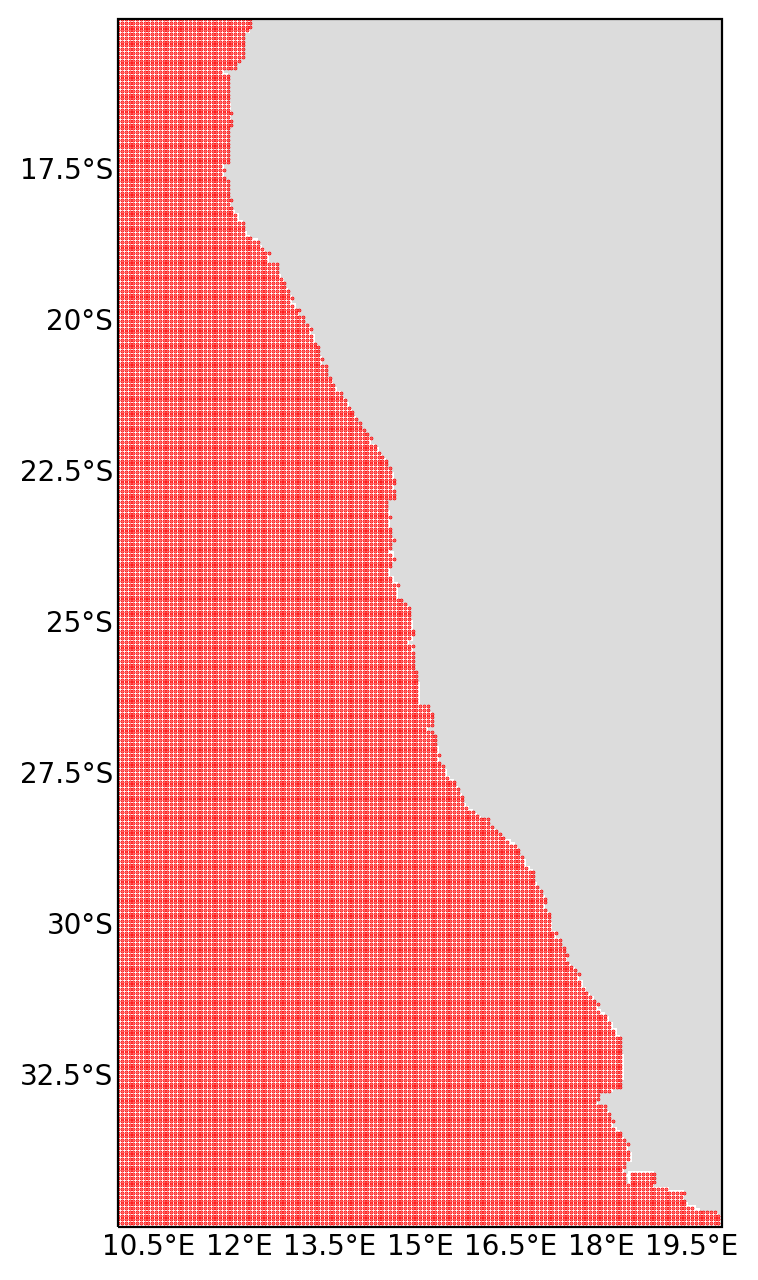

In [57]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
# ax.pcolormesh(mask_lon[0, :, :], mask_lat[0, :, :], mask_land[0,0, 1:, 1:], cmap=colormap)

# ax.scatter(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:],marker='X',s=0.3, c='red')
# ax.scatter(mask_lon[0, :, :], mask_lat[0, :, :], c=mask_land[0,0, :, :], cmap=plt.cm.Reds, s=0.5)
# ax.scatter(mask_lon[0, :, :], mask_lat[0, :, :],marker='X',s=0.3, c='red')


# ax.set_xlim(3,21)
# ax.set_ylim(-42,-13)
ax.set_xlim(10, 20)
ax.set_ylim(-35, -15)
ax.scatter(ocean_lons, ocean_lats, s=0.1, c="red")
plt.show()

Zoom In

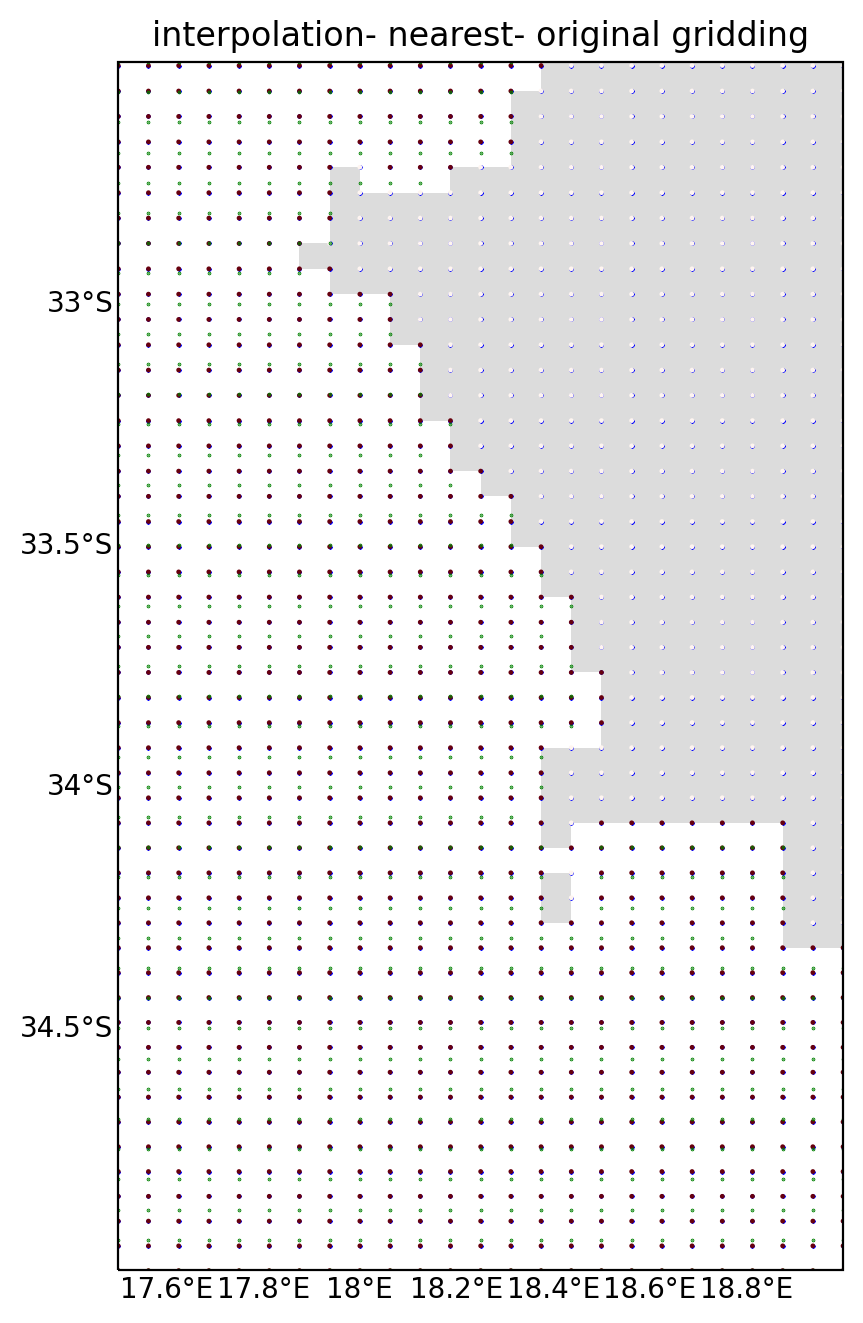

In [58]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("interpolation- nearest- original gridding")
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
# ax.pcolormesh(mask_lon[0, :, :], mask_lat[0, :, :], mask_land[0,0, 1:, 1:], cmap=colormap)

ax.scatter(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:],marker='X',s=0.3, c='blue')
ax.scatter(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:],c=mask_land[0,0, 1249:1750, 1499:], cmap=plt.cm.Reds, s=0.5)

# ax.scatter(mask_lon[0, :-1, :-1], mask_lat[0, :-1, :-1], c=mask_land[0,0, 1:, 1:], cmap=plt.cm.Reds, s=0.5)

# ax.scatter(mask_lon[0, :, :], mask_lat[0, :, :], c=mask_land[0,0, :, :], cmap=plt.cm.Reds, s=0.5)
# ax.scatter(mask_lon[0, :, :], mask_lat[0, :, :],marker='X',s=0.3, c='red')

# ax.set_xlim(13, 15)
# ax.set_ylim(-25, -22)

ax.set_xlim(17.5, 19)
ax.set_ylim(-35, -32.5)

ax.scatter(ocean_lons, ocean_lats, s=0.1, c="green")
plt.show()

In [8]:
# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_release_points_1by5_grid.npz',
#                     Longitude=ocean_lons,
#                     Latitude=ocean_lats)
# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_release_points_1601x1025_grid_015625.npz',
#                     Longitude=ocean_lons,
#                     Latitude=ocean_lats)

<h3> Example plot for computing FTLE with ocean release only</h3>
griddata method was later changed to 'nearest' as the filtering was not working well near 21E.


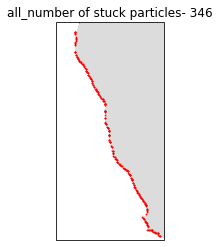

In [99]:
test_ds=xr.open_zarr('/nethome/manra003/analysis/dispersion/simulations/Test_all_Sep2023_3D_BenguelaUpwR_1ov16_321x161res_Dec2017_1z_2days.zarr')

stuck_ids = np.where(test_ds.lon[:,0]==test_ds.lon[:,-1])[0]

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("all_number of stuck particles- {0}".format(len(stuck_ids)))
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)

# ax.set_xlim(17.5, 19)
# ax.set_ylim(-35, -32.5)

ax.set_xlim(10, 20)
ax.set_ylim(-35, -15)

ax.scatter(np.take(test_ds.lon[:,-1],stuck_ids), np.take(test_ds.lat[:,-1],stuck_ids), s=0.5, c="red")
plt.show()

<h2> for shifted

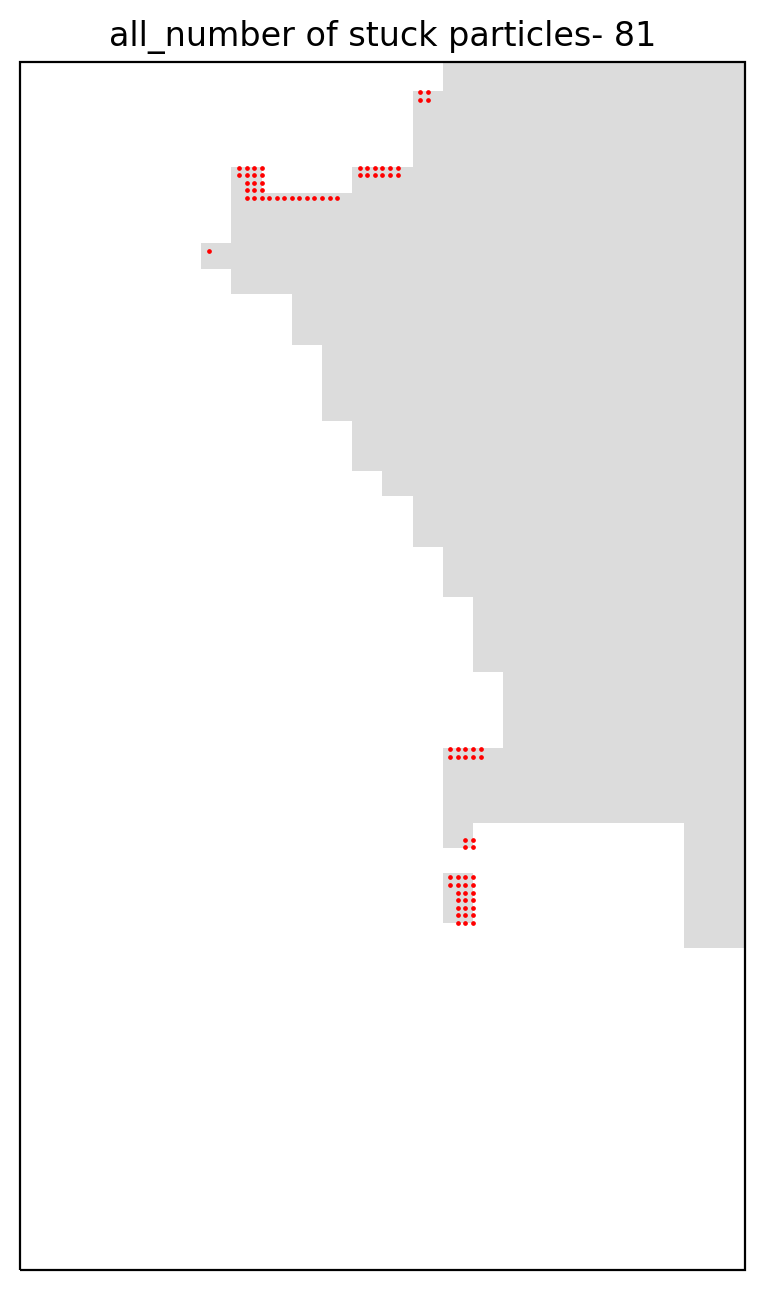

In [26]:
test_ds=xr.open_zarr('/nethome/manra003/analysis/dispersion/simulations/Test_shited_Sep2023_3D_BenguelaUpwR_1ov64_129x97res_Dec2017_1z_2days.zarr')

stuck_ids = np.where(test_ds.lon[:,0]==test_ds.lon[:,-1])[0]

fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("all_number of stuck particles- {0}".format(len(stuck_ids)))
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)


ax.set_xlim(17.5, 19)
ax.set_ylim(-35, -32.5)

# ax.set_xlim(10, 20)
# ax.set_ylim(-35, -15)

ax.scatter(np.take(test_ds.lon[:,-1],stuck_ids), np.take(test_ds.lat[:,-1],stuck_ids), s=0.5, c="red")
plt.show()

<h2> using new method- nav_lat, nav_lon for filtering.

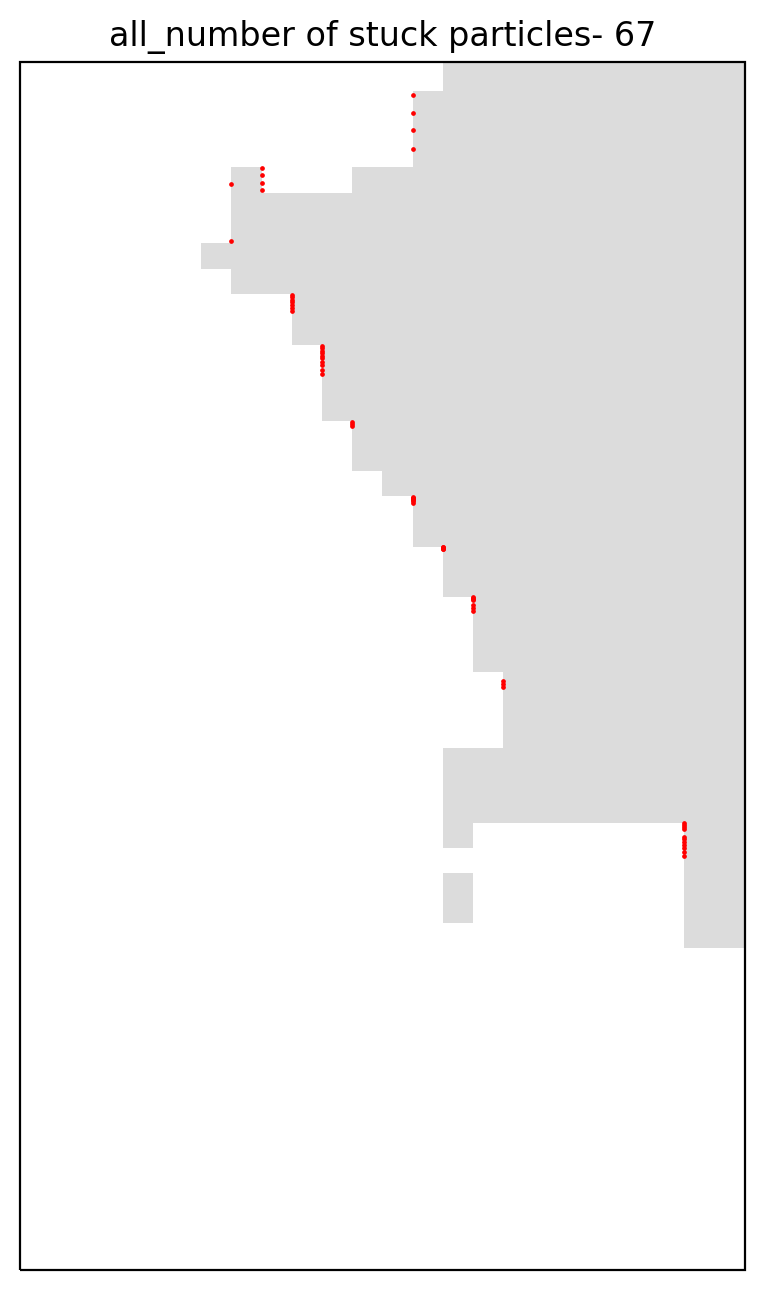

In [40]:
test_ds=xr.open_zarr('/nethome/manra003/analysis/dispersion/simulations/Test_shited_Sep2023_3D_BenguelaUpwR_1ov64_129x97res_Dec2017_1z_2days.zarr')

stuck_ids = np.where(test_ds.lon[:,0]==test_ds.lon[:,-1])[0]

fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("all_number of stuck particles- {0}".format(len(stuck_ids)))
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)


ax.set_xlim(17.5, 19)
ax.set_ylim(-35, -32.5)

# ax.set_xlim(10, 20)
# ax.set_ylim(-35, -15)

ax.scatter(np.take(test_ds.lon[:,-1],stuck_ids), np.take(test_ds.lat[:,-1],stuck_ids), s=0.5, c="red")
plt.show()

<h3> still some particles remain on land -after filtering- to use a sample simulation to remove those points for the selected resolution!

<h1> release at grid points.

In [32]:
# Create a mask based on the latitude and longitude boundaries
lat_mask = (mask_ds['nav_lat'] >= bottom_lat) & (mask_ds['nav_lat'] <= top_lat)
lon_mask = (mask_ds['nav_lon'] >= left_lon) & (mask_ds['nav_lon'] <= right_lon)
combined_mask = lat_mask & lon_mask
filtered_data = mask_ds.where(combined_mask, drop=True)

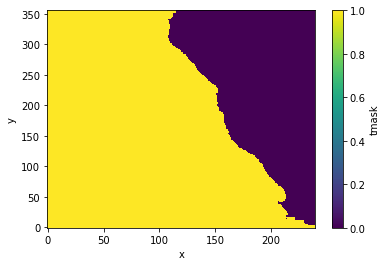

In [33]:
filtered_data.tmask[0,0,:,:].plot()

In [34]:
land_mask = (filtered_data['tmask'][0,0,:,:] == 1)

new_lats= filtered_data['nav_lat'].where(land_mask).values.flatten()

new_lons= filtered_data['nav_lon'].where(land_mask).values.flatten()
assert (new_lons==new_lats).all
new_lats= new_lats[~np.isnan(new_lats)]
new_lons= new_lons[~np.isnan(new_lons)]
print(len(new_lons))

58027


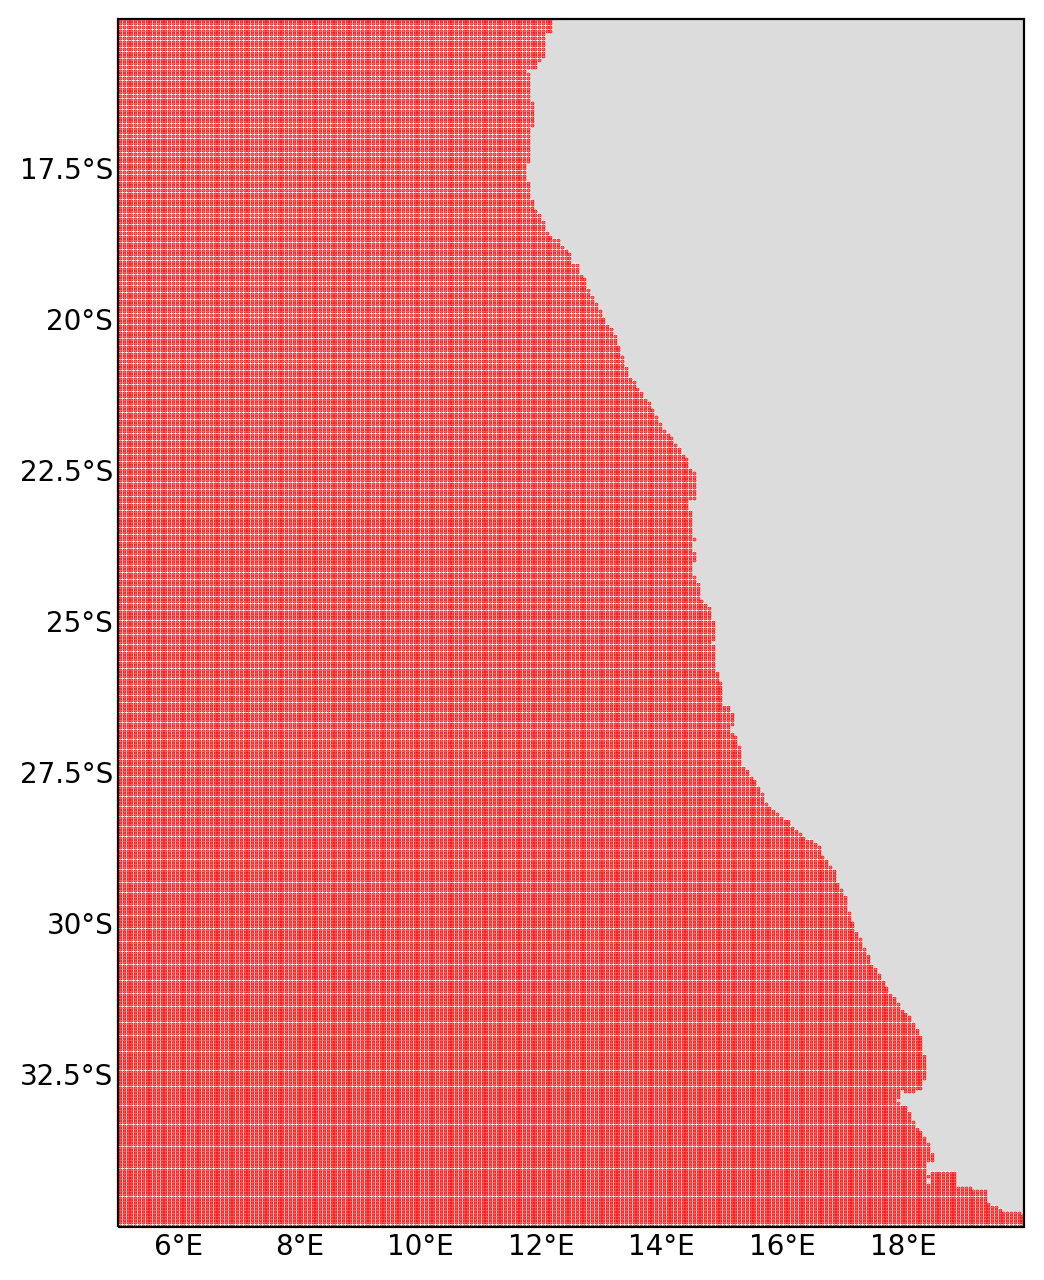

In [35]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(left_lon, right_lon)
ax.set_ylim(bottom_lat, top_lat)

ax.scatter(new_lons,new_lats, s=0.1, c="red")
plt.show()

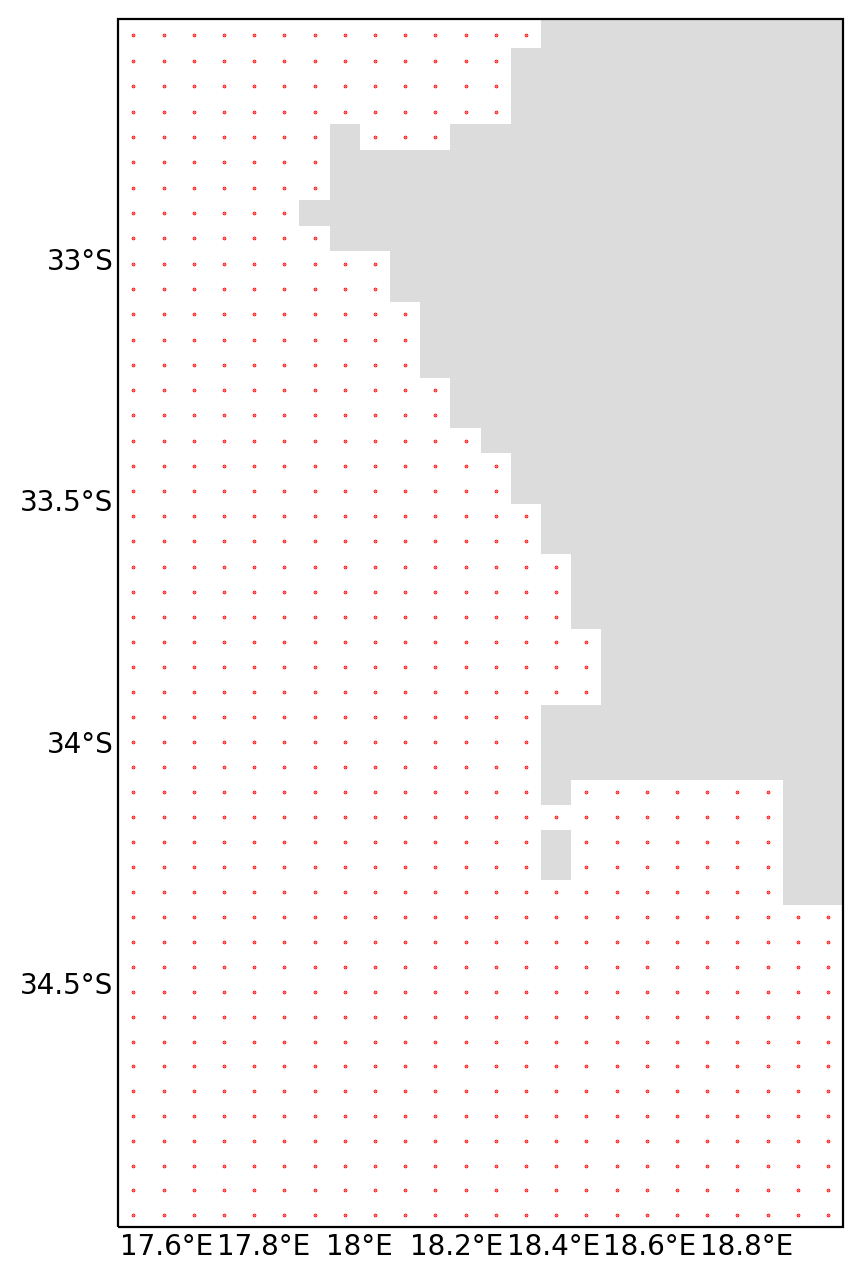

In [27]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
ax.set_xlim(17.5, 19)
ax.set_ylim(-35, -32.5)

ax.scatter(new_lons,new_lats, s=0.1, c="red")
plt.show()

In [39]:
locations = pd.DataFrame(data=[new_lons, new_lats]).T
locations.columns=['Longitude', 'Latitude']
locations.to_csv('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Release_points_1ov{0}_{1}x{2}grid.csv'.format(den, regions_lons.shape[0], regions_lons.shape[1]),
        index=False, header=True, sep=',')

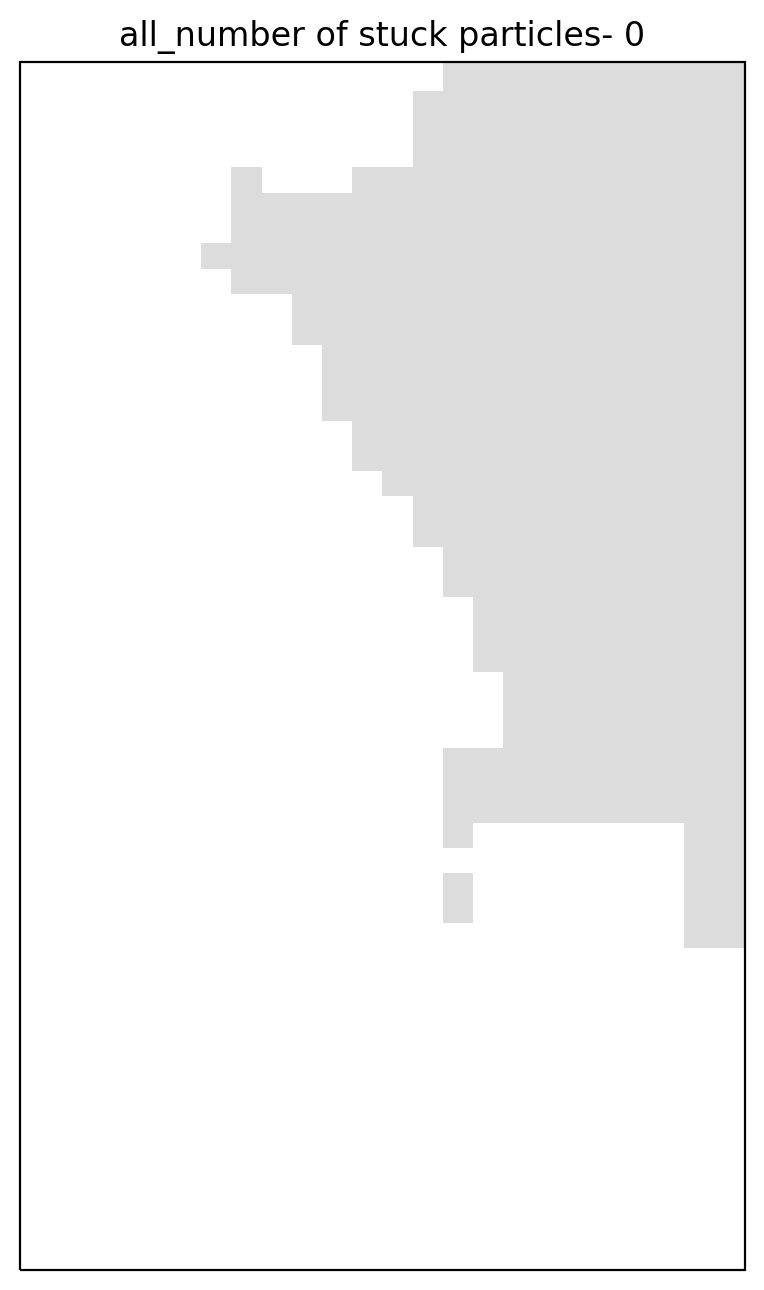

In [4]:


test_ds=xr.open_zarr('/nethome/manra003/analysis/dispersion/simulations/Test_18Sep2023_3D_BenguelaUpwR_1ov64_129x97res_Dec2017_1z_2days.zarr')

stuck_ids = np.where(test_ds.lon[:,0]==test_ds.lon[:,-1])[0]

fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("all_number of stuck particles- {0}".format(len(stuck_ids)))
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)


ax.set_xlim(17.5, 19)
ax.set_ylim(-35, -32.5)

# ax.set_xlim(10, 20)
# ax.set_ylim(-35, -15)

ax.scatter(np.take(test_ds.lon[:,-1],stuck_ids), np.take(test_ds.lat[:,-1],stuck_ids), s=0.5, c="red")
plt.show()